# Rayleigh plot for Circadian Rhythm Research
# 6/22/20 update
1. SD added inside around arrow. Width = SD. Length set at 50% of arrow length
2. stacked points added. Factor controls how far the points go inwards. Default = 0.1, which means points \
    go from 1, 0.9, 0.8...

Note: seems like it will be difficult to plot things outside for python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import astropy.stats.circstats as cs
import circular

Predefined functions

In [2]:
def save_fig(fig_id, tight_layout=True):
    os.makedirs('plots', exist_ok = True)
    path = os.path.join('plots',fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
def reverse_circa_r_test(pval,n):

    R = 4*n**2-(((1+2*n)+np.log(pval))**2-(1+4*n))
    R = np.sqrt(R/4)
    r = R/n

    return r

In [4]:
def descending_occurence(df, factor = 0.1):
    df['range'] = list(range(len(df)))
    df['ones'] = np.ones_like(df['range']) - factor*df['range']
    del df['range']
    return df


Custom function

In [5]:
def rayleigh_plot_setup(ax, schedule):

    # suppress the radial labels
    plt.setp(ax.get_yticklabels(), visible=False)

    # set the circumference labels
    ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
    ax.set_xticklabels(range(24))

    # make the labels go clockwise
    ax.set_theta_direction(-1)

    # place 0 at the top
    ax.set_theta_offset(np.pi/2.0)
    for i in range(180):
        if schedule == 'ZT':
            day_color = 'yellow'
        elif schedule == 'CT':
            day_color = 'lightgrey'
        else:
            day_color = 'white'
            print('invalid schedule')
        plt.axvspan(i*2*np.pi/360, (i+1)*2*np.pi/360, alpha=0.1, color= day_color)

    for i in range(180,360):
        plt.axvspan(i*2*np.pi/360, (i+1)*2*np.pi/360, alpha=0.1, color='dimgrey')


In [6]:
def rayleigh_plot_same(df, phase_in_ZT, group,fname, schedule = 'ZT', stacked = False, factor = 0.1):

    df['phase'] = df[phase_in_ZT]*(2*np.pi/24)
    colors = ['b','r','g','c','m','y','k']
    plt.figure(figsize = (8,8))
    ax = plt.subplot(111, polar=True)
    rayleigh_plot_setup(ax, schedule)

    
    legend_list = []
    #print('Rayleigh Test:')
    for g in range(len(df[group].unique())):
        plotting = df[df[group]==df[group].unique()[g]]
        x = plotting['phase']
        if stacked:
            tmp = pd.DataFrame(columns = plotting.columns)
            for t in plotting['phase'].unique():
                subset = plotting[plotting['phase'] == t]
                subset = descending_occurence(subset, factor)
                tmp = tmp.append(subset)
            plotting = tmp        
        else:
            plotting['ones'] = np.ones_like(plotting['phase'])
        #R_test = reverse_circa_r_test(0.05, len(plotting))
        #ax.plot(np.linspace(0, 2*np.pi, 100), np.ones(100)*R_test, color='orange', linestyle='-')
        points = ax.scatter(plotting['phase'], plotting['ones'], color = colors[g], label = df[group].unique()[g])
        arr_dir = cs.circmean(plotting['phase'])
        arr_len = circular.circ_r(plotting['phase'])
        kw = dict(arrowstyle="->", color=colors[g],linewidth = 5)
        ax.annotate("", xy=(arr_dir, arr_len), xytext=(0, 0),
                 arrowprops=kw)
        #print(arr_dir, arr_len)
        #print(df[group].unique()[g] + ': ' + str(cs.rayleightest(plotting['phase'])))
        #print(df[group].unique()[g] + ': ' + str(circular.circ_rtest(plotting['phase'])))
        sd = np.sqrt(cs.circvar(plotting['phase']))
        ax.plot(np.linspace(arr_dir - sd/2, arr_dir + sd/2, 100), np.ones(100)*arr_len*0.5, color='black', linestyle='-')
       
        plt.legend()
    
    # put the points on the circumference
    plt.ylim(0,1.02)
    #print(legend_list)
    #plt.legend(handles = legend_list, loc = 'upper center',bbox_to_anchor=(1.3, 0.8))
    plt.title(fname,y = 1.1)
    plt.grid('off')

    save_fig(fname)
    plt.show()

In [7]:
def rayleigh_plot_separate(df, phase_in_ZT, group,fname, schedule = 'ZT', stacked = False, factor = 0.1):
    df['phase'] = df[phase_in_ZT]*(2*np.pi/24)
    colors = ['b','r','g','c','m','y','k']
    n_plot = df[group].nunique()
    plt.figure(figsize = (8,4))
    for g in range(len(df[group].unique())):
        ax = plt.subplot(1,n_plot, g+1, polar=True, clip_on = False)
        rayleigh_plot_setup(ax, schedule)


        legend_list = []


        plotting = df[df[group]==df[group].unique()[g]]
        x = plotting['phase']
        if stacked:
            tmp = pd.DataFrame(columns = plotting.columns)
            for t in plotting['phase'].unique():
                subset = plotting[plotting['phase'] == t]
                subset = descending_occurence(subset, factor)
                tmp = tmp.append(subset)
            plotting = tmp
            
        else:
            plotting['ones'] = np.ones_like(plotting['phase'])
        R_test = reverse_circa_r_test(0.05, len(plotting))
        
        ax.plot(np.linspace(0, 2*np.pi, 100), np.ones(100)*R_test, color='orange', linestyle='-')
        points = ax.scatter(plotting['phase'], plotting['ones'], color = colors[g], label = df[group].unique()[g])
        arr_dir = cs.circmean(plotting['phase'])
        arr_len = circular.circ_r(plotting['phase'])
        kw = dict(arrowstyle="->", color=colors[g], linewidth = 3)
        ax.annotate("", xy=(arr_dir, arr_len), xytext=(0, 0),
                 arrowprops=kw)
        
        sd = np.sqrt(cs.circvar(plotting['phase']))
        #print(sd)
        ax.plot(np.linspace(arr_dir - sd/2, arr_dir + sd/2, 100), np.ones(100)*arr_len*0.5, color='black', linestyle='-')
        #plt.legend()

        # put the points on the circumference
        plt.ylim(0,1.05)
        #print(legend_list)
        #plt.legend(handles = legend_list, loc = 'upper center',bbox_to_anchor=(1.3, 0.8))
        plt.title(fname + '_' + df[group].unique()[g],y = 1.1)
        plt.grid('off')

    save_fig(fname + '_sep')
    plt.show()


# Main function

In [8]:
data = pd.DataFrame({'ZT':[5,7,7,8,10,12,15,20],'Genotype':['WT']*4+['KO']*4})
# data = pd.read_csv('filename.csv')
#data.head()
data.to_csv('dummy_data.csv')

/Users/tsofoon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/tsofoon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tsofoon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

Saving figure Test rayleigh plot


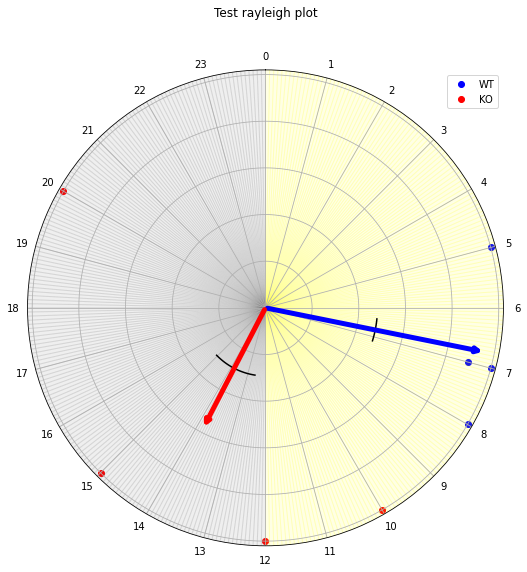

In [9]:
rayleigh_plot_same(data,'ZT','Genotype', 'Test rayleigh plot', schedule = 'ZT', stacked=True)

/Users/tsofoon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/tsofoon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tsofoon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

Saving figure Test rayleigh plot_sep


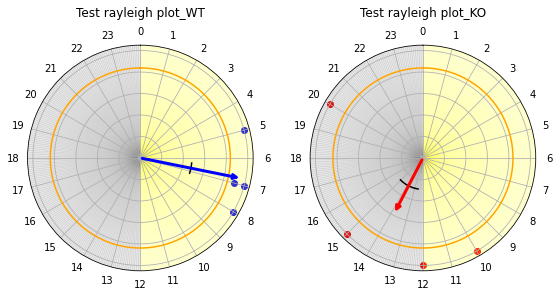

In [10]:
rayleigh_plot_separate(data,'ZT','Genotype', 'Test rayleigh plot', schedule = 'ZT', stacked = True, factor = 0.1)

